# Lab 1 - Creating a CNN Classifier

In this lab, you will use your choice of PyTorch or Keras to create a convolutional neural network (CNN) to classify the vehicle images you prepared in the previous lab.

> **Important**: If you did not complete Lab 1, use the sample solution notebook for that lab to prepare the training images you will need in this lab!

## Set up a Deep Learning Framework
You can choose to build your CNN using **PyTorch** or **Keras**. You'll need to install the framework you want to use, and then import it (and any of its libraries you need to use):

> **Hints**:
> - Use the `pip` utility to install the framework - you can run shell commands in a notebook by prefixing the code with a **!** character

In [1]:
# !pip install https://download.pytorch.org/whl/cpu/torch-1.0.1.post2-cp36-cp36m-linux_x86_64.whl
# !pip install torchvision

# Import PyTorch libraries
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

print("Libraries imported - ready to use PyTorch", torch.__version__)


%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np
from PIL import Image
import os

Libraries imported - ready to use PyTorch 1.3.1










## Prepare the Data

In the following cell, write code to load the training data and split it into a training set and a validation set.

>**Hints**:
> - If you are using PyTorch, use **ImageDataGenerator** objects to load the data. If you are using Keras, use **DataLoader** objects.
> - Normalize the pixel values in the range 0-255 as you load them.
> - Split the data into 70% for training, 30% for validation.
> - Create a list of class names that corresponds to the class labels in your dataset.

In [2]:


# The images are in a folder named 'shapes/training'
#training_folder_name = "../library/data/classification/training"
training_folder_name = "../data/classification/training2"
# The folder contains a subfolder for each class of shape
classes = sorted(os.listdir(training_folder_name))
print(classes)

['automobile', 'plane', 'train']


In [3]:
# from PIL import Image, ImageOps
# import matplotlib.pyplot as plt
# %matplotlib inline
# catagories = os.listdir(training_folder_name)

# tracker = 1
# for root, dirs, files in os.walk(training_folder_name):
#     try:
#         if os.path.split(root)[1] == 'training':
#             pass
#         else:
#             sFiles = sorted(files)
#             for i in sFiles:
#                 #print(i)
#                 #print(catagories[tracker-1])
#                 image = Image.open(os.path.join(root, i))
#                 size  = image.size
#                 if size != (128, 128):
#                     print(i)
#                     print(catagories[tracker-1])
#                     print(image.size)
#             tracker += 1
#     except IndexError:
#         pass
# plt.show()

In [4]:
def find_train_test_len(data, train_perc, test_perc):
    assert train_perc + test_perc == 1., "Percentages must add to 100"
    len_data = len(data)
    train_len = int(len_data*train_perc)
    test_len = len_data - train_len
    return train_len, test_len
    


def Data_Loadup(Data_Path):
    #create data transformer (Convert to tensors and normalize data)
    transformer = transforms.Compose([transforms.RandomHorizontalFlip(0.5),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])])
    
    #load & transform data
    DataSet = torchvision.datasets.ImageFolder(root = Data_Path, transform = transformer)
    
    #Determine lengths of training and testing sets
    train_len, test_len = find_train_test_len(DataSet, 0.7, 0.3)
    
    #Split data into training and testing sets
    train_set, test_set = torch.utils.data.random_split( DataSet, [train_len, test_len] )
    
    #Set up the Data Loaders (feeds loaded data to CNN)
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=18, num_workers=0, shuffle=False)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=18, num_workers=0, shuffle=False)
    
    return train_loader, test_loader

# Get the iterative dataloaders for test and training data
train_loader, test_loader = Data_Loadup(training_folder_name)
batch_size = train_loader.batch_size
print("Data loaders ready to read", training_folder_name)


Data loaders ready to read ../data/classification/training2


## Define the CNN
Define the layers in your CNN:

> **Hints**:
> - Use *convolution* layers to extract feature based on filter kernels.
> - Use pooling layers to downsample the extracted features.
> - To improve your model, experiment with adding layers (making the network deeper) and adding filters (making the network broader).

In [15]:
class my_CNN(nn.Module):
    
    #Define constructor
    def __init__(self, num_classes=3):
        #Ensures proper MRO
        super(my_CNN, self).__init__()
        
        #Define Layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=24, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=24, out_channels=48, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=24, out_channels=24, kernel_size=3, stride=1, padding=1)
        #self.conv4 = nn.Conv2d(in_channels=48, out_channels=144, kernel_size=3, stride=1, padding=1)
        
        self.drop  = nn.Dropout2d(p=0.15)
        self.dropfc= nn.Dropout2d(p=0.5)
        self.pool  = nn.MaxPool2d(kernel_size=2)
        self.fc    = nn.Linear(in_features=16*16*48, out_features=num_classes)
        #self.fc    = nn.Linear(in_features=16*16*48, out_features=num_classes)
        
    #Define Forward Function (How the CNN goes through the layers and data)
    def forward(self, x): 
        #Layer 1 goes: 12 filters > 1 pooling > RELU
        x = F.relu(self.pool(self.conv1(x)))
        x = self.drop(x)
        x = F.relu(self.pool(self.conv3(x)))
        x = self.drop(x)
        x = F.relu(self.conv3(x))
        x = self.drop(x)
        
        x = F.relu(self.conv3(x))
        x = self.drop(x)
        #Layer 2 goes: 24 filters > 1 pooling > RELU
        #x = F.relu(self.pool(self.conv2(x)))
        
        #Layer 3 goes: 48 filters > 1 pooling > RELU
        x = F.relu(self.pool(self.conv2(x)))
        x = self.drop(x)

        #Flatten Output
        #x = x.view(-1, 32*32*24)
        x = x.view(-1, 16*16*48)
        
        x = self.dropfc(self.fc(x))
        #Return class probabilities
        return torch.log_softmax(x, dim=1)
    

# #Set the device to which the device is allocated
# device = 'cpu'
# if (torch.cuda.is_available()):
#     device = 'cuda'
    
# #Create model Instance
# model = my_CNN(num_classes=3).to(device)
# print(model)

            
        

### Import Pre-Built Model (ResNet34)

In [7]:
model = torchvision.models.resnet34(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
    
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(classes))

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Train the Model

Train the model using the training dataset, and validating after each epoch with the validation dataset.

> **Hints**:
> - Choose an appropriate optimizer and learning rate - Refer to the [PyTorch](https://pytorch.org/docs/stable/optim.html#algorithms) or [Keras](https://keras.io/optimizers/) framework documentation as you experiment with this.
> - Run the training process over a reasonable number of epochs - start with 15 and increase / decrease based on your observations of validation loss.
> - Track both training and validation loss so you can observe training progress and plot the loss history after training.

In [10]:
def train(model, device, train_loader, optimizer, epoch):
    model.train
    train_loss = 0 
    print("Epoch: ", epoch)
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(target)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_criteria(output, target)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        print('\tTraining batch {} Loss:{:.6f}'.format(batch_idx+1, loss.item()))
        
    avg_loss = train_loss / (batch_idx + 1)
    print('Training set: Average loss: {:.6f}'.format(avg_loss))
    return avg_loss

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        batch_count = 0
        for data, target in test_loader:
            batch_count += 1
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += loss_criteria(output, target).item()
            _, predicted = torch.max(output.data, 1)
            correct += torch.sum(target == predicted).item()
        avg_loss = test_loss / batch_count
        print('Validation Set: Average Loss:{:.6f}, Accuracy:{}/{} ({:.0f}%)\n'.format(
            avg_loss, correct, len(test_loader.dataset), 
            100. * correct / len(test_loader.dataset)))
        return avg_loss
    
    
#Set the device to which the device is allocated
device = 'cpu'
if (torch.cuda.is_available()):
    device = 'cuda'    

    
optimizer = optim.Adam(model.parameters(), lr = 0.001)
loss_criteria = nn.CrossEntropyLoss()
epoch_nums = []
training_loss = []
validation_loss = []

epochs = 10
print('Training on ', device )
for epoch in range(1, epochs+1):
    train_loss = train(model, device, train_loader, optimizer, epoch)
    test_loss  = test(model, device, test_loader)
    epoch_nums.append(epoch)
    training_loss.append(train_loss)
    validation_loss.append(test_loss)
    
        

Training on  cpu
Epoch:  1
	Training batch 1 Loss:0.793905
	Training batch 2 Loss:0.809396
	Training batch 3 Loss:0.721905
	Training batch 4 Loss:0.748564
	Training batch 5 Loss:0.771620
	Training batch 6 Loss:0.671755
	Training batch 7 Loss:0.542736
	Training batch 8 Loss:0.830158
	Training batch 9 Loss:0.459240
	Training batch 10 Loss:0.564194
Training set: Average loss: 0.691347
Validation Set: Average Loss:0.520061, Accuracy:61/72 (85%)

Epoch:  2
	Training batch 1 Loss:0.368471
	Training batch 2 Loss:0.391744
	Training batch 3 Loss:0.354563
	Training batch 4 Loss:0.470679
	Training batch 5 Loss:0.295455
	Training batch 6 Loss:0.408218
	Training batch 7 Loss:0.303657
	Training batch 8 Loss:0.505158
	Training batch 9 Loss:0.218339
	Training batch 10 Loss:0.290617
Training set: Average loss: 0.360690
Validation Set: Average Loss:0.322633, Accuracy:68/72 (94%)

Epoch:  3
	Training batch 1 Loss:0.254298
	Training batch 2 Loss:0.167795
	Training batch 3 Loss:0.225639
	Training batch 4 L

## View Loss History

Use matplotlib to plot the training and validation loss history.

> **Hints**:
> - Experiment with adding model layers and filters, changing activation functions,, or using a different optimizer or learning rate to achieve a lower loss - you should restart the kernel between each attempt!
> - If the training loss continues to drop, but the validation loss doesn't - the model is *overfitting*. We'll explore options to address this later in the course.

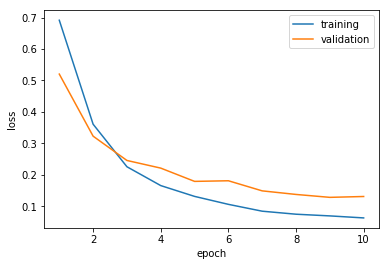

In [11]:


plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

## View Model Performance

Plot a confusion matrix to observe how the model performs:

> **Hints**:
> - Use some or all of the validation data to generate metrics for the confusion matrix.
> - Use the **sklearn.metrics.confusion_matrix** object to create the confusion matrix.

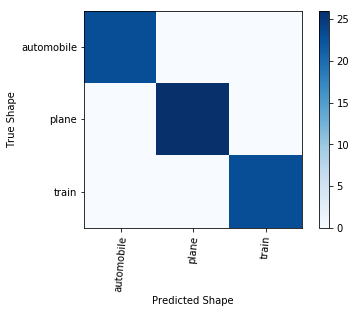

In [12]:


#set-up for evaluation
truelabels   = []
predicitions = []
model.eval()

for data, target in test_loader:
    for label in target.data.numpy():
        truelabels.append(label)
    for predicition in model(data).data.numpy().argmax(1):
        predicitions.append(predicition)
        
cm = confusion_matrix(truelabels, predicitions)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=85)
plt.yticks(tick_marks, classes)
plt.xlabel("Predicted Shape")
plt.ylabel("True Shape")
plt.show()

## Save the Model Weights

After you've trained the model, save the model weights so you can reuse it later.

> **Hints**:
> - Save the weights, not the entire model.
> - See [Keras documentation](https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model) for information about saving Keras model weights, or [PyTorch documentation](https://pytorch.org/tutorials/beginner/saving_loading_models.html) for information about saving PyTorch weights. 

In [13]:
model_file = 'vehicle_classifier_resnet34.pt'
torch.save(model.state_dict(), model_file)
print('Saved')
del model


Saved


## Use the Model to Classify New Images

Now you can use your model to infer the class of new images.

> **Hints**:
- Use the images in the **../data/classification/test** folder to test your model.
- Remember to prepare your new imagfes the same way you prepared the training images - they must be the same size and have the same transformations applied to them.
- Consider creating functions to encapsulate image preparation class prediction.

In [19]:
def predict_image(classifier, image_array):
    classifier.eval()
    class_names = ['automobile', 'train', 'plane']
    transformation = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])])
    image_tensor = torch.stack([transformation(image).float() for image in image_array])
    
    
    input_features = image_tensor
    predictions = classifier(input_features)
    predicted_classes = []
    
    for prediction in predictions.data.numpy():
        class_idx = np.argmax(prediction)
        predicted_classes.append(class_names[class_idx])
        
    return np.array(predicted_classes)

model_file = 'vehicle_classifier_resnet34.pt'


model = torchvision.models.resnet34()
model.load_state_dict(torch.load(model_file))

test_folder = "../data/classification/training/train"
test_images = os.listdir(test_folder)

image_arrays = []


for file in test_images:
    img = np.array(Image.open(os.path.join(test_folder, file)))
    image_arrays.append(img)
    

predictions = predict_image(model, np.array(image_arrays))

fig = plt.figure(figsize=(200, 200))
for idx, prediction in enumerate(predictions):
    if idx < 5:
        a = fig.add_subplot(1, len(predictions), idx+1)
        imgplot = plt.imshow(image_arrays[idx])
        a.set_title(prediction)
        

RuntimeError: Error(s) in loading state_dict for ResNet:
	size mismatch for fc.weight: copying a param with shape torch.Size([3, 512]) from checkpoint, the shape in current model is torch.Size([1000, 512]).
	size mismatch for fc.bias: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([1000]).